In [1]:
import os
from dotenv import load_dotenv
from google.cloud import storage

# Load environment variables from a .env file located in the same directory as this script
load_dotenv()

# Now you can access the environment variable
cloud_project = os.getenv("GOOGLE_CLOUD_PROJECT_NAME")
key_path = os.getenv("GOOGLE_CLOUD_KEY_PATH")

# Initialize a Google Cloud Storage client
client = storage.Client()

# Your bucket name
bucket_name = "hotspotstoplight_floodmapping"

# Create a GCS Bucket object
bucket = client.get_bucket(bucket_name)

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_path

In [91]:
import rasterio
from rasterio import windows

gcs_paths = [
    "gs://hotspotstoplight_floodmapping/data/costa_rica/inputs/input_data_2018-10-02.tif",
    "gs://hotspotstoplight_floodmapping/data/costa_rica/inputs/input_data_2021-07-22.tif",
]

tile_size = 256

In [95]:
import os
import numpy as np

# Directory where you want to save the tiles
output_dir = "costa_rica_temp_outputs"

# Create the directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# Ensure GDAL is configured to work with GCS URLs
os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "YES"
os.environ["CPL_VSIL_CURL_ALLOWED_EXTENSIONS"] = "tif"

In [96]:
from itertools import product

def get_tiles(ds, width=tile_size, height=tile_size):
    nols, nrows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, nols, width), range(0, nrows, height))
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in offsets:
        window = windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

In [97]:
tiles_filenames = []  # This list will store the filenames of all saved tiles


for input_geotiff in gcs_paths:
    with rasterio.open(input_geotiff) as src:
        tile_index = 0
        for window, transform in get_tiles(src):
            # Read band 2 for the current window (tile)
            band2 = src.read(2, window=window)
            
            # Check if band 2 has any non-zero values
            if np.any(band2 != 0):  # If true, proceed to process and save the tile
                tile = src.read(window=window)  # Read all bands for the window
                
                # Check and pad each band if the image is not 256x256
                padded_tile = np.zeros((tile.shape[0], 256, 256), dtype=tile.dtype)
                for i in range(tile.shape[0]):  # Iterate over each band in the tile
                    band = tile[i, :, :]
                    padded_band = np.pad(band, 
                                         ((0, max(0, 256 - band.shape[0])), 
                                          (0, max(0, 256 - band.shape[1]))), 
                                         mode='constant', constant_values=0)
                    padded_tile[i, :, :] = padded_band
                
                # Update metadata with new dimensions if padding was applied
                meta = src.meta.copy()
                meta.update({
                    "driver": "GTiff",
                    "height": 256,
                    "width": 256,
                    "transform": transform
                })
                
                # Generate a unique filename for the tile
                unique_part = input_geotiff.split('/')[-1].replace('.tif', '')
                filename = f'{unique_part}_tile_{tile_index}.tif'
                full_path = os.path.join(output_dir, filename)
                
                with rasterio.open(full_path, 'w', **meta) as dst:
                    dst.write(padded_tile)
                tiles_filenames.append(full_path)  # Append the full path to the list
            tile_index += 1

In [ ]:
import random
import matplotlib.pyplot as plt
import rasterio
import numpy as np

# Ensure there are enough tiles for sampling
num_samples = min(len(tiles_filenames), 10)
random_tiles = random.sample(tiles_filenames, num_samples)

# Display the randomly selected tiles, filtering out tiles where band 2 has only 0 values (i.e., landcover is empty, so it's over ocean)
for tile_filename in random_tiles:
    with rasterio.open(tile_filename) as tile:
        data = tile.read(2)  # Read the second band of the tile
        
        # Check if the entire band contains only 0 values
        if np.any(data != 0):  # If there's at least one non-zero value, proceed
            plt.figure()
            plt.imshow(data, cmap='viridis')
            plt.title(tile_filename)
            plt.colorbar()
            plt.show()
        else:
            print(f"Skipped {tile_filename} because band 2 contains only 0 values.")

In [3]:
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples
from torchgeo.samplers import RandomGeoSampler

In [4]:
gcs_path = "gs://hotspotstoplight_floodmapping/data/costa_rica/inputs/input_data_2018-10-02.tif"

with rasterio.open(gcs_path) as src:
    img = src.read()
    img_transform = src.transform

In [5]:
import ee
ee.Authenticate()
ee.Initialize(project=cloud_project)

In [6]:
import restee as ree

# get an authenticated cloud session for requesting data
session = ree.EESession(cloud_project, key_path)

In [16]:
import geemap

image = geemap.load_GeoTIFF(gcs_path)
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
cr= countries.filter(ee.Filter.eq("country_na", "Costa Rica"))
cr_domain = ree.Domain.from_ee_geometry(session,cr,resolution=0.005)
# request the ee.Image pixels as a xarray dataset for the domain
image_xr = ree.img_to_xarray(session, cr_domain, image, no_data_value=0)


In [20]:
import xarray as xr
from sklearn.preprocessing import OneHotEncoder

In [21]:
import numpy as np

In [56]:
# One-hot encode the landcover band
landcover_data = np.array(image_xr['landcover'])
encoder = OneHotEncoder(sparse_output=False)
landcover_encoded = encoder.fit_transform(landcover_data.reshape(-1, 1))

# Assuming the original dimensions (height and width) are accessible
height, width = landcover_data.shape

# Reshape landcover_encoded to a 3D array: height x width x number of encoded classes
landcover_encoded_reshaped = landcover_encoded.reshape(height, width, -1)

# Pull the flooded_mask band into a separate np array
flooded_mask = np.array(image_xr['flooded_mask'])

# Convert other bands to numpy arrays
other_bands = [band for band in image_xr.data_vars if band not in ['landcover', 'flooded_mask']]
other_data = np.stack([np.array(image_xr[band]) for band in other_bands], axis=-1)
# Concatenate landcover_encoded_reshaped with other_data along the third dimension (bands)
other_data= np.concatenate([other_data, landcover_encoded_reshaped], axis=-1)

In [46]:
print(type(other_data))

<class 'numpy.ndarray'>


In [89]:
# return the min and max values of each band in other_data
min_values = np.min(other_data, axis=(0, 1))
max_values = np.max(other_data, axis=(0, 1))

print(min_values, max_values)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.]


In [67]:
import numpy as np

def drop_all_nan_bands(data):
    """
    Drops bands that contain all NaN values from a 3D NumPy array.

    Parameters:
    - data: A 3D NumPy array of shape (height, width, bands).

    Returns:
    - A 3D NumPy array with bands containing all NaN values removed.
    """
    # Check for NaNs across the height and width dimensions
    # This will result in a boolean array where True indicates a band is all NaN
    is_nan_band = np.all(np.isnan(data), axis=(0, 1))

    # Use the boolean array to select bands that are not all NaN
    filtered_data = data[:, :, ~is_nan_band]

    return filtered_data

# Apply the function to your data
filtered_other_data = drop_all_nan_bands(other_data)

# Verify the shape before and after to see the effect
print("Original shape:", other_data.shape)
print("Filtered shape:", filtered_other_data.shape)

Original shape: (639, 682, 24)
Filtered shape: (639, 682, 22)


In [90]:
import numpy as np

def min_max_scale(array):
    # Use np.nanmin and np.nanmax to ignore nan values
    min_val = np.nanmin(array)
    max_val = np.nanmax(array)
    print(min_val, max_val)
    # Avoid division by zero and handle the case where all values are nan
    if max_val == min_val or np.isnan(min_val) or np.isnan(max_val):
        # Optionally, handle this case differently
        # For example, you could return an array of zeros with the same shape
        return np.zeros_like(array)
    else:
        # Scale the array, ignoring nan values in the original array
        # This will preserve nan values in their original positions
        scaled_array = (array - min_val) / (max_val - min_val)
        return scaled_array

# Apply min-max scaling to each band in the array
scaled_data = np.stack([min_max_scale(filtered_other_data[:, :, i]) for i in range(filtered_other_data.shape[-1])], axis=-1)

-8.0 3767.0
1.0 63.0
1.0 24.0
1.0 128.0
91.0 943.0
-521.0 32767.0
1.0 32767.0
1.0 32767.0
-32768.0 32767.0
-62.0 50.0
1.0 113.0
1.0 359.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


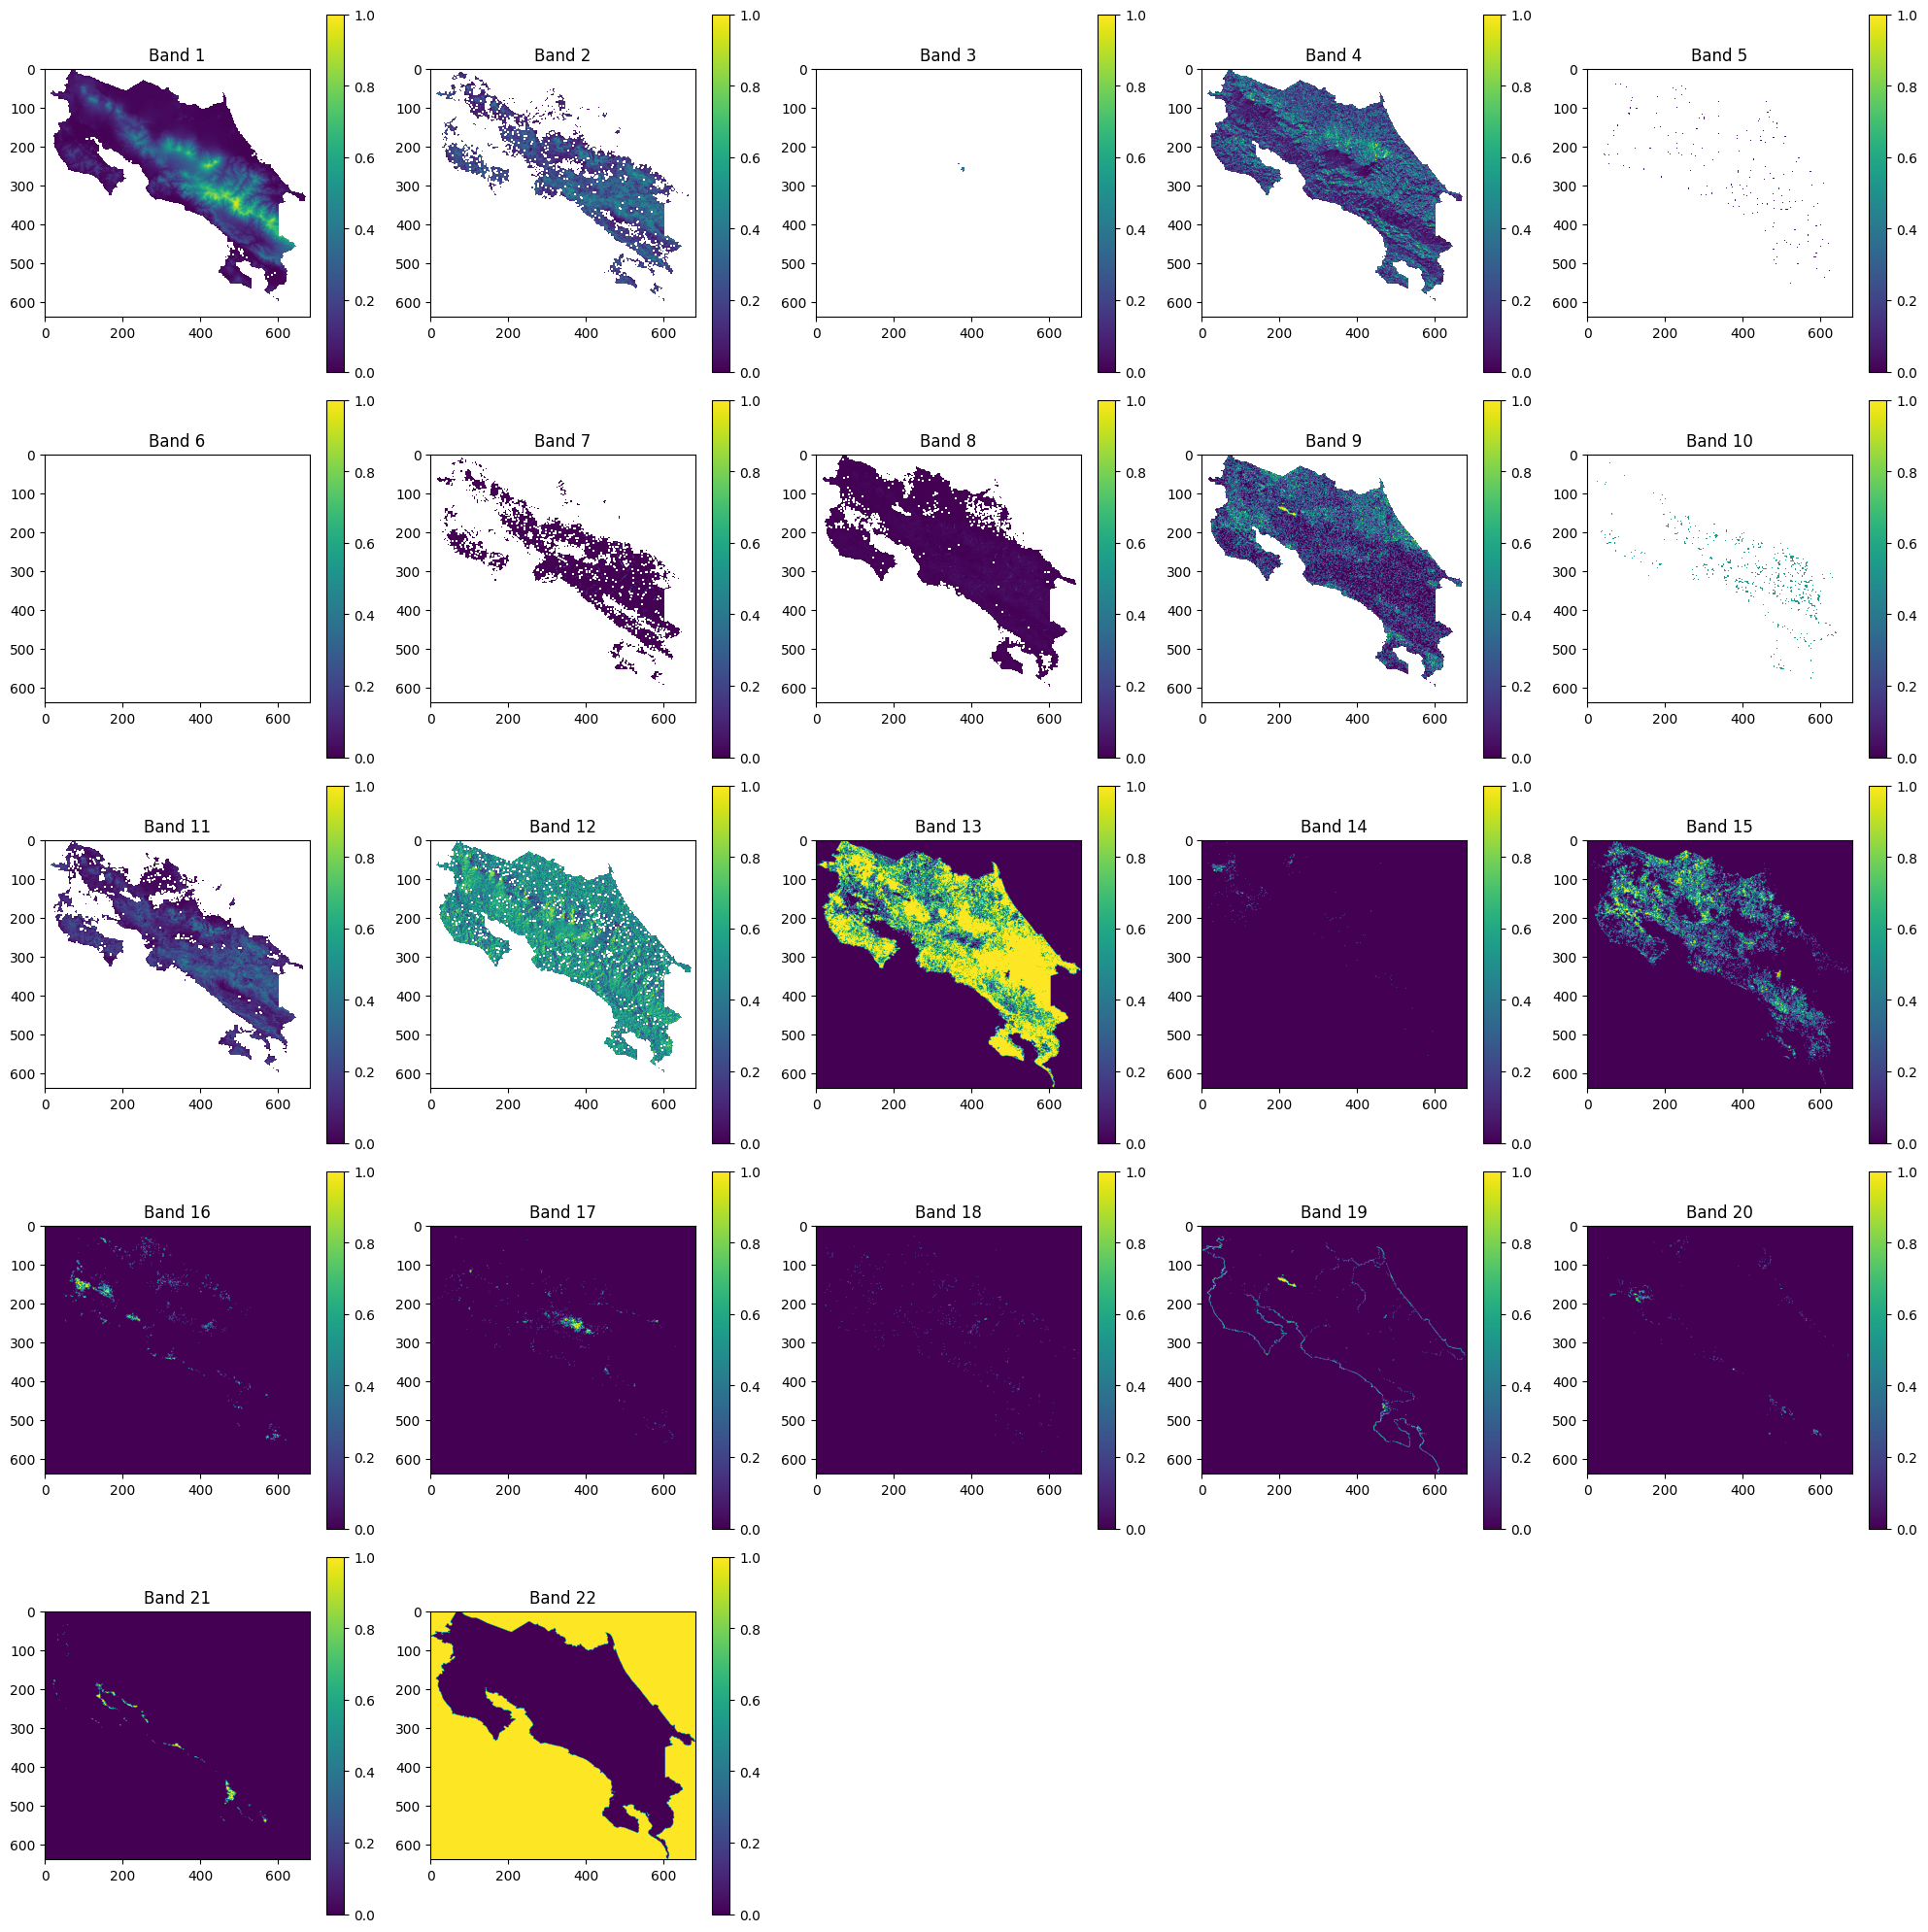

In [69]:
# plot the first band in other_data using matplotlib
import matplotlib.pyplot as plt

# Assuming other_data is your 3D array with shape (height, width, bands)
bands = scaled_data.shape[2]

# Calculate grid size for plots
n_cols = int(np.ceil(np.sqrt(bands)))  # Number of columns
n_rows = int(np.ceil(bands / n_cols))  # Number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

for i in range(bands):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    im = ax.imshow(scaled_data[:, :, i], cmap='viridis')
    ax.set_title(f'Band {i+1}')
    fig.colorbar(im, ax=ax)

# If the number of subplots is not a perfect square, some subplots might be empty and can be turned off.
for i in range(bands, n_rows * n_cols):
    axes.flat[i].axis('off')

plt.tight_layout()
plt.show()

In [70]:
# replace NanNs with 0 in flooded_mask
flooded_mask = np.nan_to_num(flooded_mask)

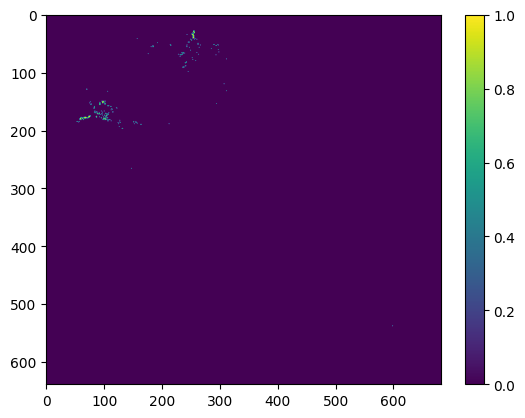

In [71]:
# plot the flooded_mask using matplotlib
plt.imshow(flooded_mask, cmap='viridis')
plt.colorbar()
plt.show()

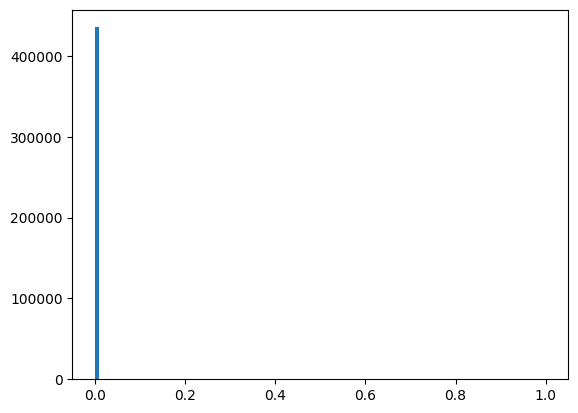

In [72]:
# print a histogram of the flooded mask values
plt.hist(flooded_mask.flatten(), bins=100)
plt.show()

In [73]:
from torch.utils.data import Dataset
import torch
import numpy as np
import math

class FloodDataset(Dataset):
    def __init__(self, features, labels, tile_size=256, padding_value=0):
        """
        Initializes the dataset with features, labels, and tile size.
        Applies padding to ensure all tiles are of the specified size.

        Parameters:
        - features: NumPy array of shape (height, width, num_features).
        - labels: NumPy array of shape (height, width), representing the flood mask.
        - tile_size: The size of the tiles to extract (default is 256).
        - padding_value: The value used for padding incomplete tiles (default is 0).
        """
        self.tile_size = tile_size
        self.padding_value = padding_value

        # Calculate necessary padding
        pad_height = tile_size - (features.shape[0] % tile_size) if features.shape[0] % tile_size != 0 else 0
        pad_width = tile_size - (features.shape[1] % tile_size) if features.shape[1] % tile_size != 0 else 0

        # Apply padding
        self.features = np.pad(features, ((0, pad_height), (0, pad_width), (0, 0)), 'constant', constant_values=padding_value)
        self.labels = np.pad(labels, ((0, pad_height), (0, pad_width)), 'constant', constant_values=padding_value)

        # Convert to torch tensors
        self.features = torch.from_numpy(self.features).float().permute(2, 0, 1)  # Shape: (num_features, height, width)
        self.labels = torch.from_numpy(self.labels).long()  # Shape: (height, width)

        # Calculate the number of tiles
        self.num_tiles_height = math.ceil(features.shape[0] / tile_size)
        self.num_tiles_width = math.ceil(features.shape[1] / tile_size)

    def __len__(self):
        # The total number of tiles in the dataset
        return self.num_tiles_height * self.num_tiles_width

    def __getitem__(self, idx):
        # Calculate tile row and column
        row = idx // self.num_tiles_width
        col = idx % self.num_tiles_width

        # Calculate pixel indices
        start_row = row * self.tile_size
        start_col = col * self.tile_size
        end_row = start_row + self.tile_size
        end_col = start_col + self.tile_size

        # Extract the tile and label
        feature_tile = self.features[:, start_row:end_row, start_col:end_col]
        label_tile = self.labels[start_row:end_row, start_col:end_col]

        return feature_tile, label_tile

In [74]:
# Assuming other_data is your features and flooded_mask is your labels
flood_dataset = FloodDataset(features=scaled_data, labels=flooded_mask)

# Then, create a DataLoader for batch processing
dataloader = DataLoader(flood_dataset, batch_size=32, shuffle=True)

In [85]:
# Ensure DataLoader and FloodDataset are already defined and initialized

# Flag to indicate if NaN values are found
nan_found_in_features = False
nan_found_in_labels = False

# Iterate over the DataLoader
for features, labels in dataloader:
    # Check for NaN values in features and labels
    if torch.isnan(features).any():
        nan_found_in_features = True
        print("NaN values found in features.")
        break  # Stop checking further if NaN values are found
    
    if torch.isnan(labels).any():
        nan_found_in_labels = True
        print("NaN values found in labels.")
        break  # Stop checking further if NaN values are found

if not nan_found_in_features and not nan_found_in_labels:
    print("No NaN values found in the dataset.")


NaN values found in features.


In [75]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self, in_channels):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 1, kernel_size=3, padding=1)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.sigmoid(self.conv3(x))  # Sigmoid activation to output probabilities
        return x

In [82]:
model = SimpleCNN(in_channels=22) 
optimizer = optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.BCELoss()

In [83]:
num_epochs = 10

model.train()  # Set the model to training mode

for epoch in range(num_epochs):  # Define `num_epochs` according to your needs
    for batch in dataloader:
        images = batch[0]  # Assuming your dataset returns a tuple (features, labels)
        masks = batch[1].float()  # Ensure masks are float for BCELoss

        # Forward pass
        predictions = model(images)
        predictions = predictions.squeeze(1)  # Remove channel dim, if necessary

        print("Prediction min:", predictions.min().item(), "max:", predictions.max().item())
        print("Mask min:", masks.min().item(), "max:", masks.max().item())

        valid_preds = torch.isfinite(predictions)
        if valid_preds.all():
            loss = loss_fn(predictions, masks)
        else:
            print("Invalid predictions detected")
            continue  # Skip this batch or handle the situation as needed


        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        for name, param in model.named_parameters():
            if param.grad is not None and torch.isnan(param.grad).any():
                print(f"NaN gradient in {name}")

        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Prediction min: nan max: nan
Mask min: 0.0 max: 1.0
Invalid predictions detected


NameError: name 'loss' is not defined